In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


In [2]:
train = pd.read_csv("/kaggle/input/spaceship-titanic/train.csv")
test = pd.read_csv("/kaggle/input/spaceship-titanic/test.csv")
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


The dataset indicates that the passengerId takes the form gggg_pp, where gggg indicates the group the individual is travelling with and pp is their number within the group. Based on this, we can extract the number of people each individual is travelling with.

In [3]:
#Extract groups from the passenger ID
def extract_grp(x):
    splitstr = x.split("_")
    return splitstr[0]
train['Group'] = train["PassengerId"].apply(extract_grp)
test['Group'] = train["PassengerId"].apply(extract_grp)


In [4]:
#Extract number of people in one group
train_group = train.groupby("Group").count()['Cabin'].reset_index()
test_group = test.groupby("Group").count()['Cabin'].reset_index()
train_group = train_group.rename(columns = {"Cabin":"People"})
test_group = test_group.rename(columns = {"Cabin":"People"})
train = train.merge(train_group, how="inner", on="Group")
test = test.merge(test_group, how ="inner", on = "Group")
# train['People'] = train['People'].apply(lambda x: "More than 1" if x > 1 else "One")
# test['People'] = test['People'].apply(lambda x: "More than 1" if x > 1 else "One")
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Group,People
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,0001,1
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,0002,1
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,0003,2
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,0003,2
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,0004,1


The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard. Once again, we can extract the deck and the side of each passenger.

In [5]:
#Extract port or starboard status from the cabin
def extract_deck(x):
    x = str(x)
    split_str = x.split("/")
    return split_str[0]
def extract_side(x):
    x = str(x)
    split_str = x.split("/")
    return split_str[-1]

In [6]:
train['Cabin'] = train['Cabin'].apply(str)
train['Deck'] = train["Cabin"].apply(extract_deck)
test['Deck'] = test["Cabin"].apply(extract_deck)
train['Side'] = train["Cabin"].apply(extract_side)
test['Side'] = test["Cabin"].apply(extract_side)
train

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Group,People,Deck,Side
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,0001,1,B,P
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,0002,1,F,S
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,0003,2,A,S
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,0003,2,A,S
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,0004,1,F,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False,9276,1,A,P
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False,9278,1,G,S
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True,9279,1,G,S
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False,9280,2,E,S


In [7]:
#Set index back to "PassengerId"
train = train.set_index("PassengerId")
test = test.set_index("PassengerId")
categorical_cols = [cols for cols in train if train[cols].dtype == "object"]
categorical_cols

['HomePlanet',
 'CryoSleep',
 'Cabin',
 'Destination',
 'VIP',
 'Name',
 'Group',
 'Deck',
 'Side']

First, let's analyse the distribution of the transported values based on different categorical variables. First off, we analyse "Homeplantet".

<Axes: xlabel='Transported', ylabel='count'>

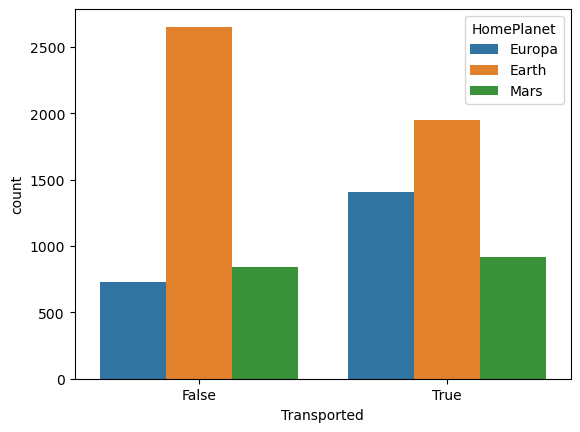

In [8]:
sns.countplot(x="Transported", data = train, hue = "HomePlanet")

Based on this, we can conclude that passengers who came from Earth are less likely to be transported. Next, we analyse "CryoSleep"

<Axes: xlabel='Transported', ylabel='count'>

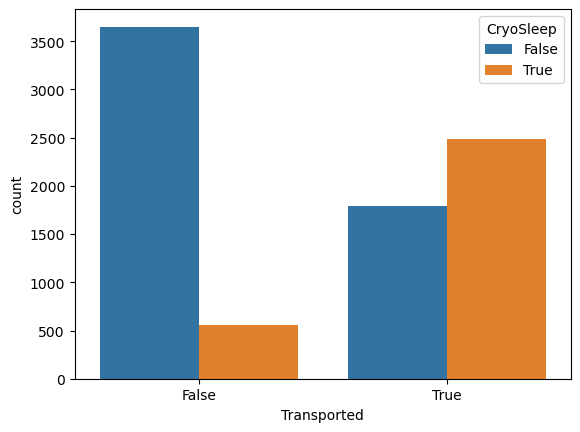

In [9]:
sns.countplot(x="Transported", data=train,hue="CryoSleep")

Passengers who are not in cryosleep are less likely to be transported. Next off, we analyse "Destination".

<Axes: xlabel='Transported', ylabel='count'>

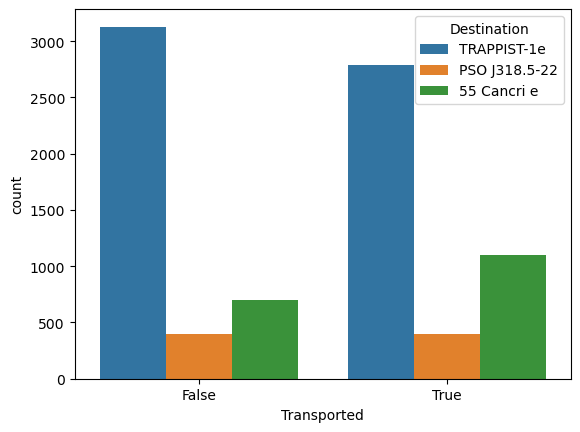

In [10]:
sns.countplot(x="Transported", data=train, hue="Destination")

From this, we can conclude that passengers are equally likely to be transported regardless of their destinaations. We can probably drop this feature. Next, we analyse "VIP".

<Axes: xlabel='Transported', ylabel='count'>

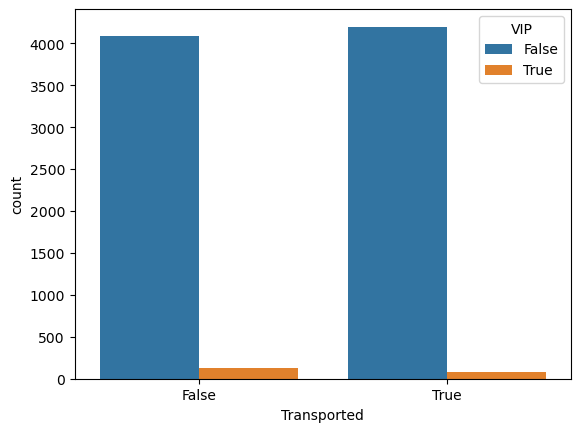

In [11]:
sns.countplot(x="Transported", data=train, hue="VIP")

Once again, passengers are equally likely to be transported no regardless of whether they paid for the VIP package or not. We can probably drop this feature too. Next, we analyse "People".

<Axes: xlabel='Transported', ylabel='count'>

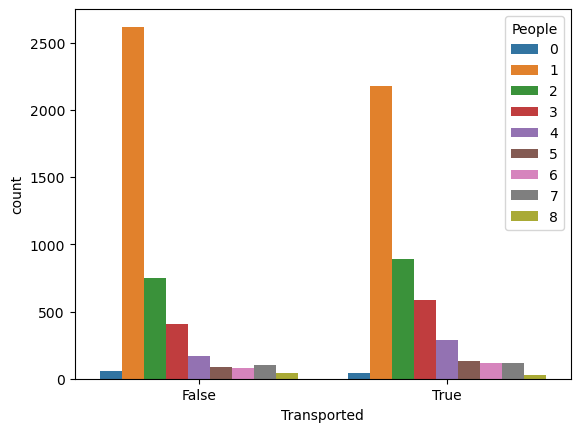

In [12]:
sns.countplot(x="Transported",data=train,hue="People")

People who travel in a group are more likely to be transported? Next we analyse the "Deck" feature.

<Axes: xlabel='Transported', ylabel='count'>

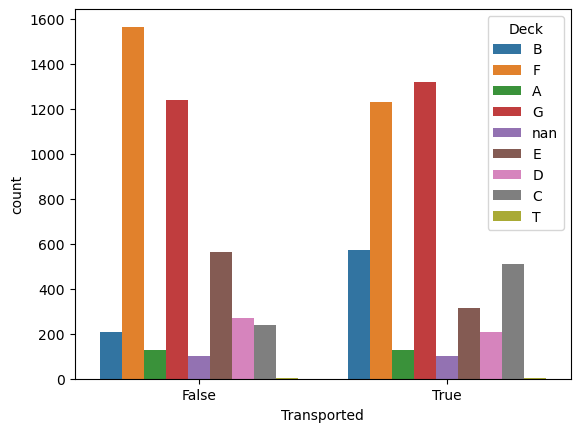

In [13]:
sns.countplot(x="Transported", data=train, hue="Deck")

<Axes: xlabel='Transported', ylabel='count'>

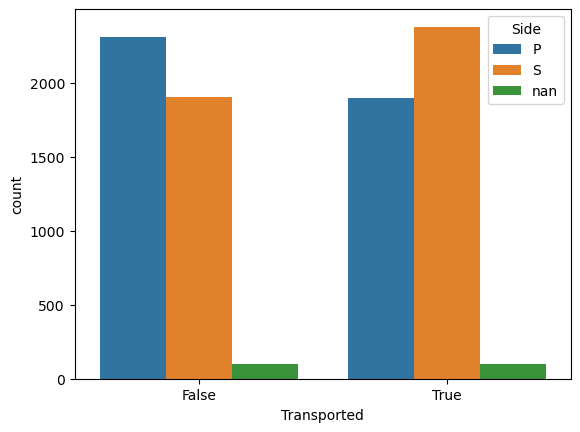

In [14]:
sns.countplot(x="Transported", data=train, hue="Side")

The passengers who belong to the side "S" are more likely to be transported. Next we can analyse the different numerical features.

/tmp/ipykernel_20/1534458401.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(train.corr(), annot=True)


<Axes: >

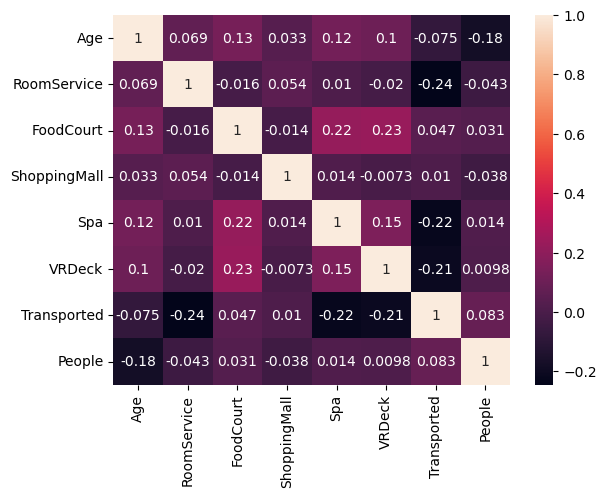

In [15]:
sns.heatmap(train.corr(), annot=True)

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


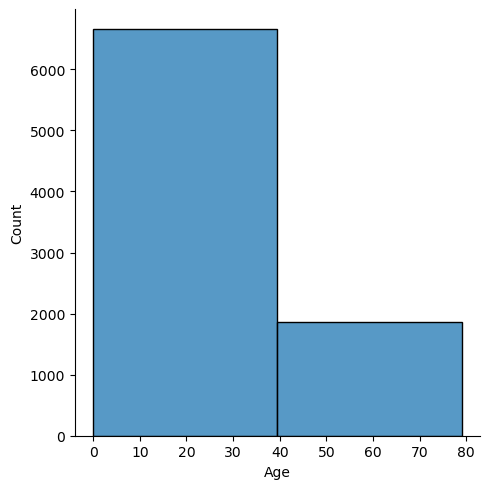

In [16]:
sns.displot(x="Age", data=train, bins = 2)

Based on this, we can conclude that 

In [17]:
def age_groups(x):
    if x >= 40:
        return "Above or equal 40"
    else:
        return "Below 40"

In [18]:
train['Age Group'] = train['Age'].apply(age_groups)
test['Age Group'] = test['Age'].apply(age_groups)

Let's analyse how the effects of the different age groups on the "Transported" feature.

<Axes: xlabel='Transported', ylabel='count'>

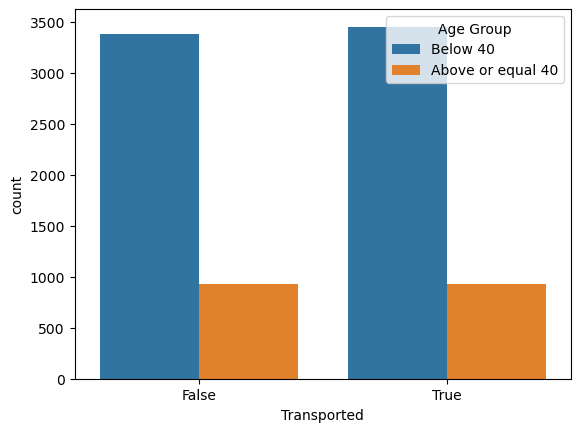

In [19]:
sns.countplot(x="Transported", data = train, hue = "Age Group")

This shows that different age groups are equally likely to be transported. Furthermore, since there is a low correlation between transported and age, we can probably remove the age and age group features.

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


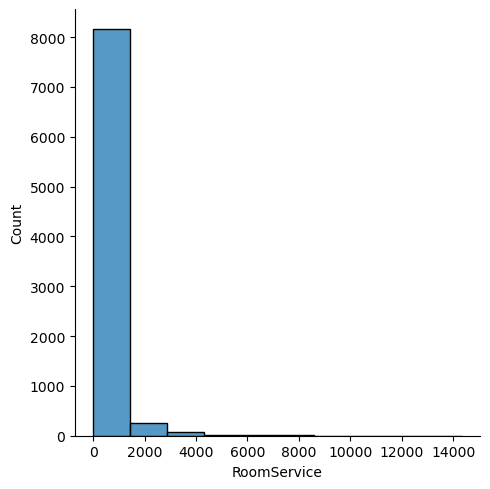

In [20]:
sns.displot(x="RoomService", data=train, bins = 10)

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


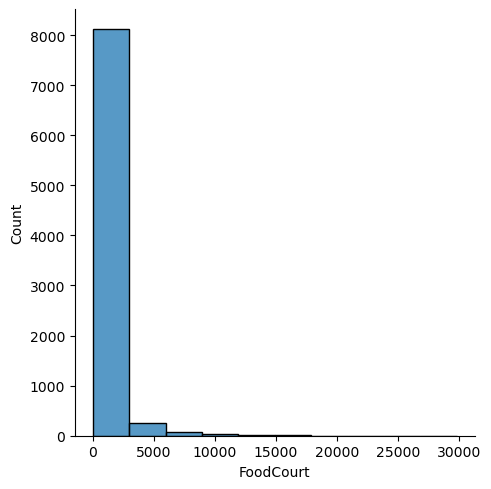

In [21]:
sns.displot(x="FoodCourt", data=train, bins = 10)

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


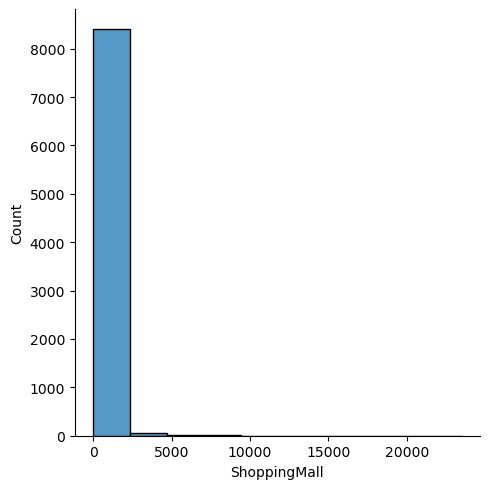

In [22]:
sns.displot(x="ShoppingMall", data=train, bins = 10)

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


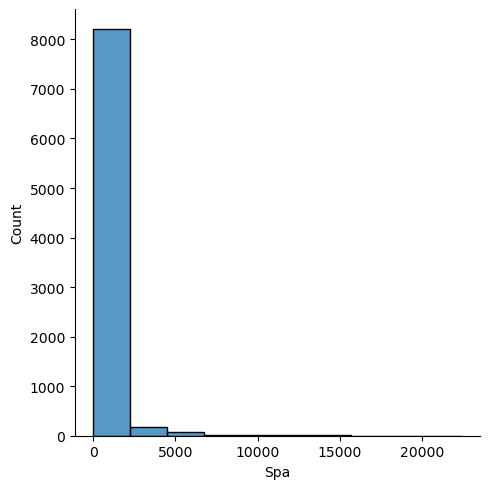

In [23]:
sns.displot(x="Spa", data=train, bins = 10)

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


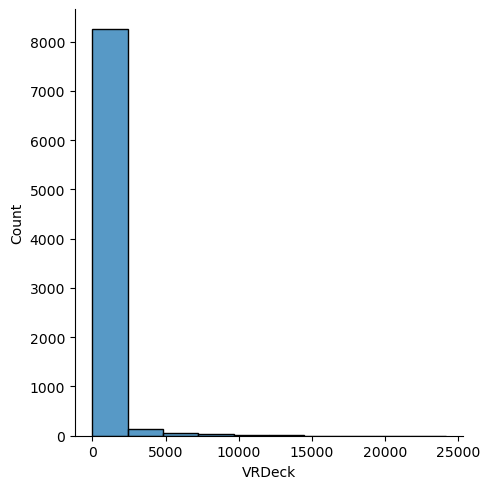

In [24]:
sns.displot(x="VRDeck", data=train, bins = 10)

In [25]:
def spending(cols):
    total = 0
    for i in range(len(cols)):
        total = total + cols[i]
    return total

In [26]:
train['Total'] = train[['VRDeck', 'FoodCourt','Spa', 'ShoppingMall','RoomService']].apply(spending, axis = 1)
test['Total'] = test[['VRDeck', 'FoodCourt','Spa', 'ShoppingMall','RoomService']].apply(spending, axis = 1)

In [27]:
train = train.drop(["VIP", "Destination", "People", "Age Group"],axis = 1)
test = test.drop(["VIP", "Destination", "People", "Age Group"],axis = 1)

In [28]:
train

,HomePlanet,CryoSleep,Cabin,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Group,Deck,Side,Total
PassengerId,,,,,,,,,,,,,,,
0001_01,Europa,False,B/0/P,39.0,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,0001,B,P,0.0
0002_01,Earth,False,F/0/S,24.0,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,0002,F,S,736.0
0003_01,Europa,False,A/0/S,58.0,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,0003,A,S,10383.0
0003_02,Europa,False,A/0/S,33.0,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,0003,A,S,5176.0
0004_01,Earth,False,F/1/S,16.0,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,0004,F,S,1091.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9276_01,Europa,False,A/98/P,41.0,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False,9276,A,P,8536.0
9278_01,Earth,True,G/1499/S,18.0,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False,9278,G,S,0.0
9279_01,Earth,False,G/1500/S,26.0,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True,9279,G,S,1873.0


In [29]:
numerical_cols = [cols for cols in train if train[cols].dtype == 'float64']
categorical_cols = [cols for cols in train if train[cols].nunique()<10 and train[cols].dtype == "object"]
training_cols = numerical_cols + categorical_cols
training_cols

['Age',
 'RoomService',
 'FoodCourt',
 'ShoppingMall',
 'Spa',
 'VRDeck',
 'Total',
 'HomePlanet',
 'CryoSleep',
 'Deck',
 'Side']

In [30]:
y = train["Transported"]
X = train[training_cols]
test = test[training_cols]
X

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Total,HomePlanet,CryoSleep,Deck,Side
PassengerId,,,,,,,,,,,
0001_01,39.0,0.0,0.0,0.0,0.0,0.0,0.0,Europa,False,B,P
0002_01,24.0,109.0,9.0,25.0,549.0,44.0,736.0,Earth,False,F,S
0003_01,58.0,43.0,3576.0,0.0,6715.0,49.0,10383.0,Europa,False,A,S
0003_02,33.0,0.0,1283.0,371.0,3329.0,193.0,5176.0,Europa,False,A,S
0004_01,16.0,303.0,70.0,151.0,565.0,2.0,1091.0,Earth,False,F,S
...,...,...,...,...,...,...,...,...,...,...,...
9276_01,41.0,0.0,6819.0,0.0,1643.0,74.0,8536.0,Europa,False,A,P
9278_01,18.0,0.0,0.0,0.0,0.0,0.0,0.0,Earth,True,G,S
9279_01,26.0,0.0,0.0,1872.0,1.0,0.0,1873.0,Earth,False,G,S


In [31]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

In [32]:
le_y = LabelEncoder()
y = le_y.fit_transform(y)
X = pd.get_dummies(X, columns = categorical_cols)
test = pd.get_dummies(test, columns = categorical_cols)

In [33]:
X_train,X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [34]:
# model = RandomForestClassifier(n_estimators = 100, max_depth = 5, random_state = 0)
my_model = XGBClassifier(n_estimators = 500, learning_rate = 0.03)
my_model.fit(X_train, y_train)
pred = my_model.predict(X_test)
score = accuracy_score(y_test, pred)
score

0.8113858539390454

In [35]:
my_model.fit(X,y)
final_predictions = my_model.predict(test)
final_predictions = le_y.inverse_transform(final_predictions)
output = pd.DataFrame({"PassengerId":test.index,
                      "Transported":final_predictions})
output

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
...,...,...
4272,9266_02,True
4273,9269_01,False
4274,9271_01,True
4275,9273_01,True


In [36]:
output.to_csv("submission.csv", index = False)